In [7]:
import zipfile
import os

In [8]:
os.makedirs("/content/data", exist_ok=True)

In [9]:
fake_zip_path = "/content/Fake.csv (2).zip"

with zipfile.ZipFile(fake_zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/data")


In [10]:
true_zip_path = "/content/True.csv (2).zip"

with zipfile.ZipFile(true_zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/data")


In [11]:
os.listdir("/content/data")

['Fake.csv', 'True.csv']

In [12]:
import pandas as pd
import numpy as np

In [13]:
fake_df = pd.read_csv("/content/data/Fake.csv")
true_df = pd.read_csv("/content/data/True.csv")

In [14]:
fake_df["label"] = 0
true_df["label"] = 1

In [15]:
df = pd.concat([fake_df, true_df], axis=0)

In [16]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
df.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [19]:
df.shape

(44898, 5)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [21]:
df["label"].value_counts()

,count
label,
0,23481
1,21417


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
sns.set_style("whitegrid")

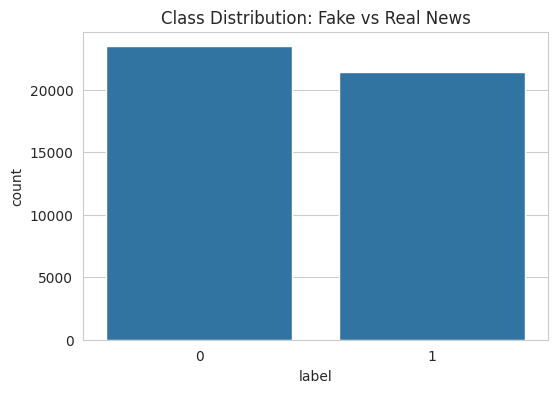

In [29]:
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df)
plt.title("Class Distribution: Fake vs Real News")
plt.show()


In [30]:
df["text_length"] = df["text"].apply(lambda x: len(str(x)))

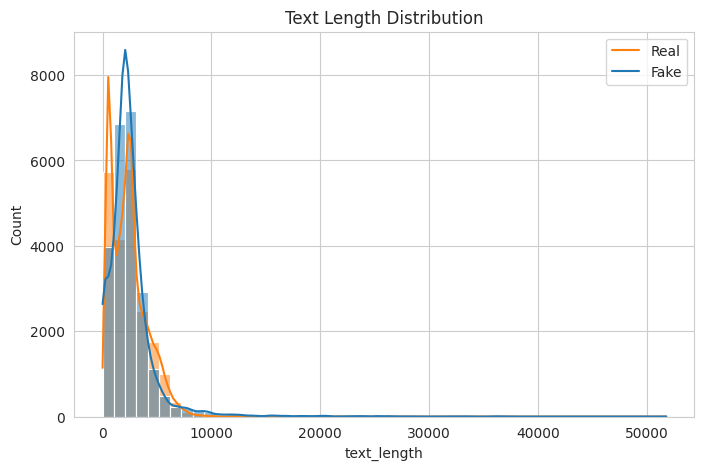

In [31]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="text_length", hue="label", bins=50, kde=True)
plt.legend(labels=["Real", "Fake"])
plt.title("Text Length Distribution")
plt.show()

# Click Bait Detector

In [33]:
df["title_length"] = df['title'].apply(lambda x: len(str(x)))

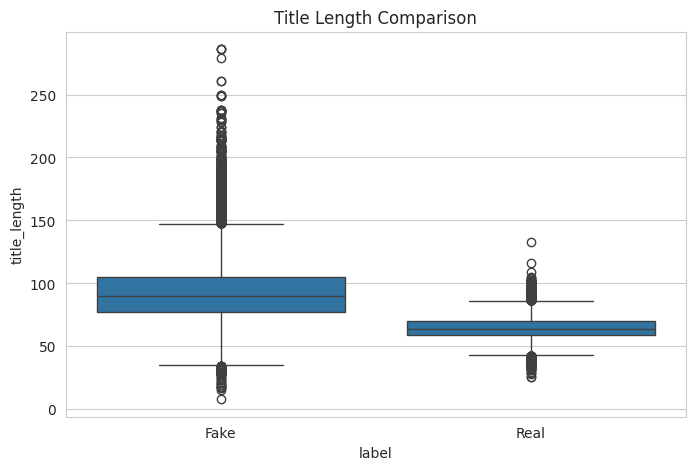

In [34]:
plt.figure(figsize=(8,5))
sns.boxplot(x="label", y="title_length", data=df)
plt.xticks([0,1], ["Fake", "Real"])
plt.title("Title Length Comparison")
plt.show()

Subject Analysis(Bias Detection)

In [35]:
df["subject"].value_counts().head(10)

,count
subject,
politicsNews,11272
worldnews,10145
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


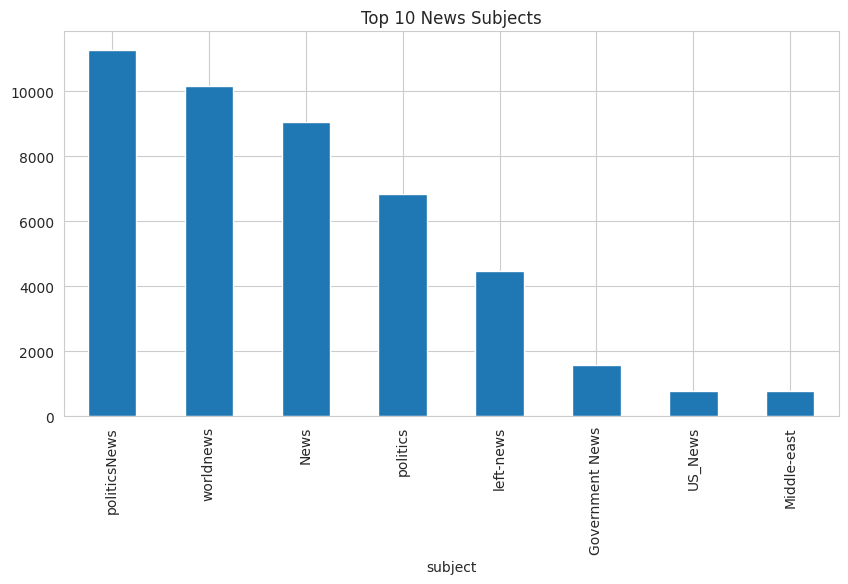

In [36]:
plt.figure(figsize=(10,5))
df["subject"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 News Subjects")
plt.show()


Word Frequency (F vs R lang)

In [37]:
fake_text = " ".join(df[df['label'] == 0]["text"].astype(str))
real_text = " ".join(df[df['label'] == 1]['text'].astype(str))

In [41]:
from collections import Counter
import re

def get_top_words(text, n=20):
  words = re.findall(r"\b[a-zA-Z]{3,}\b", text.lower())
  return Counter(words).most_common(n)

print("Top words in FAKE news:\n")
print(get_top_words(fake_text))

print("\n" + "="*50 + "\n")

print("Top words in REAL news:\n")
print(get_top_words(real_text))


Top words in FAKE news:

[('the', 543551), ('and', 226971), ('that', 151662), ('for', 93480), ('trump', 79300), ('was', 67857), ('with', 63419), ('his', 58351), ('this', 58217), ('are', 46475), ('have', 46095), ('they', 45697), ('not', 45634), ('who', 42437), ('has', 42317), ('you', 41218), ('from', 41035), ('but', 34187), ('said', 33763), ('about', 33025)]


Top words in REAL news:

[('the', 482468), ('and', 182081), ('said', 99062), ('that', 88237), ('for', 79895), ('trump', 54700), ('with', 54504), ('was', 47946), ('has', 46246), ('from', 39383), ('his', 38018), ('have', 36426), ('not', 36197), ('would', 31605), ('reuters', 28976), ('president', 28177), ('who', 27645), ('but', 26617), ('are', 26143), ('had', 25675)]


RULE-BASED LINGUISTIC FEATURE ENGINEERING

1.Exclamation Mark Density

In [42]:
def exclamation_density(text):
  if not text:
    return 0
  return text.count("!") / len(text)

In [43]:
df["exclamation_density"] = df["text"].apply(exclamation_density)

2. Capital Letter Ratio (Shouting Detector 🔊)

In [44]:
def capital_ratio(text):
  if not text:
    return 0
  capital_letters = sum(1 for c in text if c.isupper())
  return capital_letters / len(text)

In [45]:
df["capital_ratio"] = df["text"].apply(capital_ratio)

3.Sensational Keyword Count

In [46]:
sensational_words = [
    "shocking", "breaking", "exclusive", "unbelievable",
    "truth", "exposed", "secret", "bombshell"
]

def sensational_word_count(text):
  text = text.lower()
  return sum(word in text for word in sensational_words)

In [47]:
df["sensational_count"] = df["text"].apply(sensational_word_count)


4.Clickbait Phrase Score

In [51]:
clickbait_phrases = [
    "you won't believe",
    "what heppens next",
    "this will shock you",
    "doctors hate him",
    "one simple trick"
]

def clickbait_score(text):
  text = text.lower()
  return sum(phrase in text for phrase in clickbait_phrases)

In [52]:
df["clickbait_score"] = df["text"].apply(clickbait_score)


5.Emotional Manipulation Score

In [53]:
emotional_words = [
    "fear", "anger", "hate", "disaster",
    "threat", "panic", "chaos", "crisis"
]

def emotional_score(text):
    text = text.lower()
    return sum(word in text for word in emotional_words)


In [54]:
df["emotional_score"] = df["text"].apply(emotional_score)


Sanity Check

In [55]:
df[
    [
        "exclamation_density",
        "capital_ratio",
        "sensational_count",
        "clickbait_score",
        "emotional_score"
    ]
].describe()


,exclamation_density,capital_ratio,sensational_count,clickbait_score,emotional_score
count,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000
mean,0.000348,0.043705,0.310437,0.000022,0.529422
std,0.002484,0.034819,0.561657,0.004719,0.810202
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030493,0.000000,0.000000,0.000000
50%,0.000000,0.037505,0.000000,0.000000,0.000000
75%,0.000000,0.047985,1.000000,0.000000,1.000000
max,0.200000,0.882353,6.000000,1.000000,6.000000


 Readability Feature Engineering

1.Sentence Count

In [56]:
import re

def sentence_count(text):
    if not text:
        return 0
    return len(re.findall(r"[.!?]", text))


In [57]:
df["sentence_count"] = df["text"].apply(sentence_count)


2.Average Sentence Length

In [58]:
def avg_sentence_length(text):
    if not text:
        return 0
    sentences = re.split(r"[.!?]", text)
    sentences = [s for s in sentences if len(s.strip()) > 0]
    if not sentences:
        return 0
    words = [len(s.split()) for s in sentences]
    return sum(words) / len(words)


In [59]:
df["avg_sentence_length"] = df["text"].apply(avg_sentence_length)


3.Average Word Length

In [60]:
def avg_word_length(text):
    if not text:
        return 0
    words = re.findall(r"\b[a-zA-Z]+\b", text)
    if not words:
        return 0
    return sum(len(word) for word in words) / len(words)


In [61]:
df["avg_word_length"] = df["text"].apply(avg_word_length)


4.Readability Proxy Score

In [63]:
df["readability_score"] = (
    df["avg_sentence_length"] * df["avg_word_length"]
)


5.Sanity Check

In [64]:
df[
    [
        "sentence_count",
        "avg_sentence_length",
        "avg_word_length",
        "readability_score"
    ]
].describe()


,sentence_count,avg_sentence_length,avg_word_length,readability_score
count,44898.000000,44898.000000,44898.000000,44898.000000
mean,22.028554,19.015238,4.758000,92.065207
std,19.284315,6.176465,0.648216,31.620371
min,0.000000,0.000000,0.000000,0.000000
25%,10.000000,15.500000,4.620990,73.600000
50%,19.000000,18.733333,4.832684,90.041140
75%,29.000000,22.271853,5.019797,108.462174
max,774.000000,96.250000,9.000000,676.750000


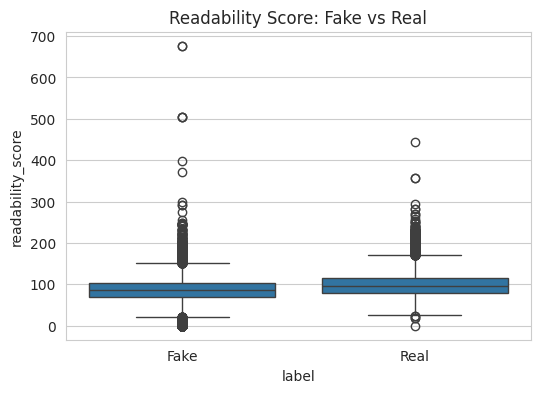

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="readability_score", data=df)
plt.xticks([0, 1], ["Fake", "Real"])
plt.title("Readability Score: Fake vs Real")
plt.show()


Hybrid Feature Fusion & Model Training”

1.Define Feature Sets

In [67]:
# Text data
X_text = df["text"]

# Numeric engineered features
numeric_features = df[
    [
        "emotional_score",
        "clickbait_score",
        "capital_ratio",
        "avg_sentence_length",
        "avg_word_length",
        "readability_score"
    ]
]

# Target
y = df["label"]


2.Train/Test Split

In [68]:
from sklearn.model_selection import train_test_split

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text, numeric_features, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


3.TF-IDF Vectorization (ML Signal)

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1,2)
)

X_tfidf_train = tfidf.fit_transform(X_text_train)
X_tfidf_test = tfidf.transform(X_text_test)


4.Feature Fusion

In [70]:
from scipy.sparse import hstack

X_train_final = hstack([X_tfidf_train, X_num_train.values])
X_test_final = hstack([X_tfidf_test, X_num_test.values])


5.Model Selection

In [71]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

model.fit(X_train_final, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

6.Predictions

In [74]:
y_pred = model.predict(X_test_final)
y_prob = model.predict_proba(X_test_final)[:, 1]


7.Model valuations

In [75]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))


              precision    recall  f1-score   support

        Fake       0.99      0.98      0.99      4696
        Real       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



confusion matrix

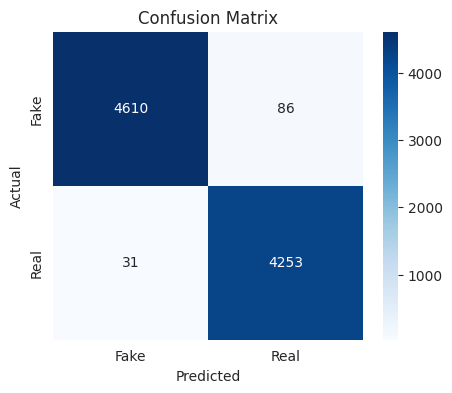

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Fake", "Real"],
            yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


ROC Curve

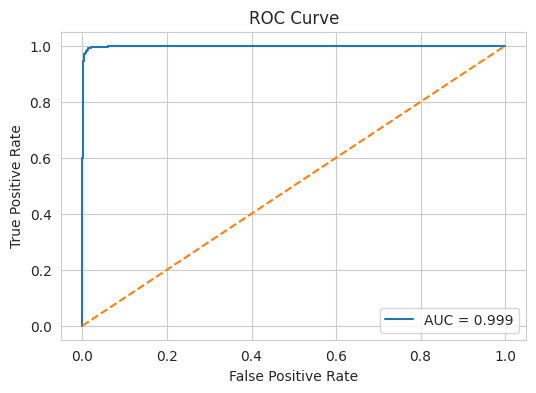

In [77]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


EXPLAINABILITY LAYER (XAI)

1 Global Explainability

In [78]:
import numpy as np
import pandas as pd

# Feature names
tfidf_features = tfidf.get_feature_names_out()
numeric_feature_names = numeric_features.columns.tolist()

all_features = np.concatenate([tfidf_features, numeric_feature_names])

coefficients = model.coef_[0]

importance_df = pd.DataFrame({
    "feature": all_features,
    "weight": coefficients
})

importance_df = importance_df.sort_values(by="weight", ascending=False)


In [79]:
print("Top REAL-indicating features:")
print(importance_df.head(10))

print("\nTop FAKE-indicating features:")
print(importance_df.tail(10))


Top REAL-indicating features:
                 feature     weight
3787             reuters  23.655036
3887                said  15.385027
4857  washington reuters   9.240803
3371    president donald   5.405772
3789   reuters president   4.765493
3717          republican   4.478506
4882           wednesday   4.433138
4666             tuesday   4.321566
4854          washington   4.240148
3019                 nov   3.858329

Top FAKE-indicating features:
              feature    weight
908               com -4.126577
2087          hillary -4.265344
2901               mr -4.482749
1704         featured -4.693691
2192            image -4.767866
1936              gop -4.781667
1705   featured image -4.785090
3379  president trump -5.169659
2441             just -5.529494
3583             read -5.607349


LOCAL EXPLANATION (Per Article)

1 Human-Readable Explanation Function

In [80]:
def explain_prediction(text, numeric_values):
    text_vec = tfidf.transform([text])
    combined_vec = hstack([text_vec, numeric_values])

    prob_real = model.predict_proba(combined_vec)[0][1]
    prediction = "REAL" if prob_real > 0.5 else "FAKE"

    explanation = {
        "prediction": prediction,
        "credibility_score": round(prob_real, 3),
        "readability_score": numeric_values[0, -1],
        "emotion_score": numeric_values[0, 0],
        "caps_ratio": numeric_values[0, 2]
    }

    return explanation


2.MEMORY & FEEDBACK SYSTEM

In [81]:
memory = []

def store_feedback(text, model_prediction, user_feedback):
    memory.append({
        "text": text,
        "model_prediction": model_prediction,
        "user_feedback": user_feedback
    })


2.2Use Memory to Adjust Trust

In [82]:
def adjust_score(base_score, memory, text):
    for entry in memory:
        if entry["text"] == text:
            if entry["user_feedback"] == "incorrect":
                return base_score * 0.7
    return base_score


In [83]:
{
  "verdict": "FAKE",
  "credibility_score": 0.21,
  "signals": {
      "ml_model": "Low semantic reliability",
      "rule_based": "High emotional language detected",
      "readability": "Below professional journalism standards"
  },
  "explanation": "The article uses emotionally charged wording, excessive capitalization, and low linguistic complexity, which are common indicators of fake news."
}


{'verdict': 'FAKE',
 'credibility_score': 0.21,
 'signals': {'ml_model': 'Low semantic reliability',
  'rule_based': 'High emotional language detected',
  'readability': 'Below professional journalism standards'},
 'explanation': 'The article uses emotionally charged wording, excessive capitalization, and low linguistic complexity, which are common indicators of fake news.'}

In [84]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("tfidf.pkl", "wb") as f:
    pickle.dump(tfidf, f)
